In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from datetime import date
from dateutil.parser import parse
import numpy as np
from sklearn import preprocessing
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import graphviz

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:\\Users\COBENA\Desktop\Learn\Code\FTW\Capstone Idea\Automotive\Web Scraping\\080119_pk and carmudi_complete.csv')

## EDA

In [3]:
final_df=df.copy()

In [4]:
#replaced null color values as 'No Color'. Same for fuel type.
final_df['Color Family']=final_df['Color Family'].fillna('No Color')
final_df['Fuel Type']=final_df['Fuel Type'].fillna('No Fuel Type')

In [5]:
#deleted Poster, Version and Description
final_df.drop(columns=['Poster','Version','Description','Title','Used','name','retail','Date Posted'],inplace=True,axis=1)
final_df.head()

,ID,Price,Brand,Model,Year of Manufacture,Transmission,Color Family,Mileage (in km),Body Type,Poster Type,Fuel Type,Location.2,Post Age
0,CAR000001,299000,Chevrolet,Cruze,2012,Automatic,No Color,60000.0,Saloon / Sedan,Individual,Gasoline,Paranaque,16
1,CAR000002,828000,Chevrolet,Captiva,2016,Automatic,Brown,NaN,SUV,Dealer,Diesel,Manila,15
2,CAR000003,450000,Chevrolet,Sail,2018,Automatic,No Color,6000.0,Saloon / Sedan,Individual,Gasoline,Quezon City,20
3,CAR000004,450000,Chevrolet,Sail,2016,Automatic,White,6000.0,Saloon / Sedan,Individual,Gasoline,Quezon City,20
4,CAR000005,468000,Chevrolet,Captiva,2011,Automatic,No Color,87000.0,SUV,Dealer,Diesel,Makati,22


In [6]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20088 entries, 0 to 20087
Data columns (total 13 columns):
ID                     20088 non-null object
Price                  20088 non-null int64
Brand                  20088 non-null object
Model                  20088 non-null object
Year of Manufacture    20088 non-null int64
Transmission           20088 non-null object
Color Family           20088 non-null object
Mileage (in km)        15562 non-null float64
Body Type              20088 non-null object
Poster Type            20088 non-null object
Fuel Type              20088 non-null object
Location.2             20088 non-null object
Post Age               20088 non-null int64
dtypes: float64(1), int64(3), object(9)
memory usage: 2.0+ MB


In [7]:
final_df.describe()

,Price,Year of Manufacture,Mileage (in km),Post Age
count,2.008800e+04,20088.000000,1.556200e+04,20088.000000
mean,8.141697e+05,2012.478644,5.356116e+04,52.494524
std,1.456741e+06,5.719296,1.139158e+05,40.327707
min,5.000000e+03,1962.000000,1.000000e+00,5.000000
25%,3.680000e+05,2010.000000,1.900000e+04,27.000000
50%,5.680000e+05,2014.000000,4.316950e+04,37.000000
75%,8.880000e+05,2017.000000,7.500000e+04,67.000000
max,1.234568e+08,2020.000000,1.234568e+07,1017.000000


In [8]:
final_df=final_df[final_df['Year of Manufacture']<2020]

## Check the Data Some More

In [9]:
x=final_df['Mileage (in km)']
y=final_df['Year of Manufacture']

In [10]:
x_val=final_df['Mileage (in km)'].loc[~final_df['Mileage (in km)'].isnull()]
y_val=final_df['Year of Manufacture'].loc[~final_df['Mileage (in km)'].isnull()]

(0, 1000000)

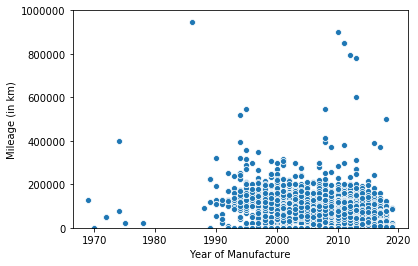

In [11]:
sns.scatterplot(y,x,data=final_df)
plt.ylim(0,1000000)

In [12]:
"""
Age and mileage should be directly correlated
Check normal distribution curve per brand
"""

'\nAge and mileage should be directly correlated\nCheck normal distribution curve per brand\n'

In [13]:
x_val_trim=x_val[x_val<700000]
y_val_trim=y_val[x_val<700000]

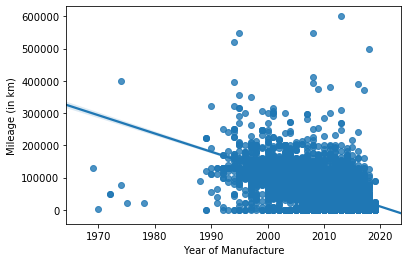

In [14]:
sns.regplot(y_val_trim,x_val_trim,data=final_df)
slope, intercept, r_value, p_value, std_err = stats.linregress(y_val_trim,x_val_trim)

In [15]:
print(slope)
print(p_value)

-5663.002492423452
0.0


## Impute Mileage Using KNN

In [16]:
X=pd.DataFrame(final_df['Year of Manufacture'].loc[final_df['Mileage (in km)'].notnull()])
X_null=pd.DataFrame(final_df['Year of Manufacture'].loc[final_df['Mileage (in km)'].isnull()])
y=pd.DataFrame(final_df['Mileage (in km)'].loc[final_df['Mileage (in km)'].notnull()])
y_null=pd.DataFrame(final_df['Mileage (in km)'].loc[final_df['Mileage (in km)'].isnull()])

In [17]:
#might have to double check the neighbors
clf=KNeighborsRegressor(3,weights='distance')
trained_model=clf.fit(X,y)

In [18]:
#predicting imputed values and setting the index to match the X_null dataframe
imputed_val=pd.DataFrame(trained_model.predict(X_null),columns=['Mileage (in km)'])
X_null.reset_index(inplace=True)

In [19]:
#merge imputed values with your Yr of Manufacture pair
null_merged=pd.merge(X_null,imputed_val,how='outer',on=X_null.index)
null_merged.drop('key_0',inplace=True,axis=1)
#index of Yr of Manufacture is set as the index
null_merged.set_index('index',inplace=True)
null_merged.rename_axis(index=None).head()

,Year of Manufacture,Mileage (in km)
1,2016,31000.000000
32,2019,6088.000000
158,2007,89250.333333
166,2004,126666.666667
173,2004,126666.666667


In [20]:
# merged them all together (Yr of Manufacture and Mileage)
xy_merged=pd.concat([X,y],axis=1)
merged_df=pd.concat([null_merged,xy_merged],axis=0)
merged_df=merged_df.sort_index()
merged_df.head()

,Year of Manufacture,Mileage (in km)
0,2012,60000.0
1,2016,31000.0
2,2018,6000.0
3,2016,6000.0
4,2011,87000.0


In [21]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20079 entries, 0 to 20087
Data columns (total 2 columns):
Year of Manufacture    20079 non-null int64
Mileage (in km)        20079 non-null float64
dtypes: float64(1), int64(1)
memory usage: 470.6 KB


In [22]:
#merge it with the whole df
total_merge=pd.merge(final_df,merged_df,on=final_df.index)
total_merge.drop(['Year of Manufacture_x','Mileage (in km)_x','key_0'],axis=1,inplace=True)
total_merge.columns=['id','price','brand','model','transmission','color','body_type','poster_type','fuel_type','location','post_age','year_of_manufacture','mileage_in_km']
total_merge.head()

,id,price,brand,model,transmission,color,body_type,poster_type,fuel_type,location,post_age,year_of_manufacture,mileage_in_km
0,CAR000001,299000,Chevrolet,Cruze,Automatic,No Color,Saloon / Sedan,Individual,Gasoline,Paranaque,16,2012,60000.0
1,CAR000002,828000,Chevrolet,Captiva,Automatic,Brown,SUV,Dealer,Diesel,Manila,15,2016,31000.0
2,CAR000003,450000,Chevrolet,Sail,Automatic,No Color,Saloon / Sedan,Individual,Gasoline,Quezon City,20,2018,6000.0
3,CAR000004,450000,Chevrolet,Sail,Automatic,White,Saloon / Sedan,Individual,Gasoline,Quezon City,20,2016,6000.0
4,CAR000005,468000,Chevrolet,Captiva,Automatic,No Color,SUV,Dealer,Diesel,Makati,22,2011,87000.0


## Time to change categorical values to numerical...

In [23]:
total_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20079 entries, 0 to 20078
Data columns (total 13 columns):
id                     20079 non-null object
price                  20079 non-null int64
brand                  20079 non-null object
model                  20079 non-null object
transmission           20079 non-null object
color                  20079 non-null object
body_type              20079 non-null object
poster_type            20079 non-null object
fuel_type              20079 non-null object
location               20079 non-null object
post_age               20079 non-null int64
year_of_manufacture    20079 non-null int64
mileage_in_km          20079 non-null float64
dtypes: float64(1), int64(3), object(9)
memory usage: 2.1+ MB


In [24]:
le = preprocessing.LabelEncoder()

In [25]:
tm_col = ['brand','model','transmission','color','body_type','poster_type','fuel_type','location']
for col in tm_col:
    total_merge[col]=le.fit_transform(total_merge[col])

In [26]:
total_merge.set_index('id',inplace=True)
total_merge.rename_axis(index=None,inplace=True)
total_merge.head()

,price,brand,model,transmission,color,body_type,poster_type,fuel_type,location,post_age,year_of_manufacture,mileage_in_km
CAR000001,299000,7,180,1,10,6,1,2,303,16,2012,60000.0
CAR000002,828000,7,146,1,4,5,0,0,254,15,2016,31000.0
CAR000003,450000,7,441,1,10,6,1,2,328,20,2018,6000.0
CAR000004,450000,7,441,1,21,6,1,2,328,20,2016,6000.0
CAR000005,468000,7,146,1,10,5,0,0,239,22,2011,87000.0


In [27]:
final_df=total_merge.copy()

## Maybe we can try imputing Mileage using median... Next time na lang haha

In [28]:
#final_df['mileage_in_km'].fillna(final_df.groupby('year_of_manufacture')['mileage_in_km'].transform('median'),inplace=True)

In [29]:
#final_df['mileage_in_km'].fillna(final_df['mileage_in_km'].median(),inplace=True)

In [30]:
#final_df[['mileage_in_km']].head()

## Model

## It's time for Decision Trees?! So we know how they split </3

In [31]:
X=final_df.drop(['price'],axis=1)
y=final_df['price']

In [32]:
dec_tree=tree.DecisionTreeRegressor(min_samples_split=4, min_samples_leaf=5,max_depth=10)

In [33]:
print(np.mean(cross_val_score(clf,X,y,cv=5)))

-0.13152253822655352


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((15059, 11), (5020, 11), (15059,), (5020,))

In [35]:
dec_tree.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [36]:
y_pred=dec_tree.predict(X_test)

Text(0, 0.5, 'Predictions')

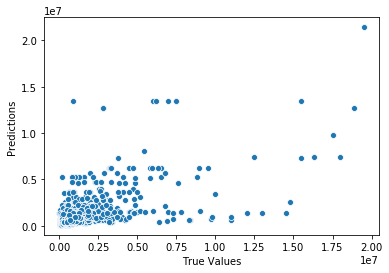

In [37]:
sns.scatterplot(y_test,y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [38]:
Xnew=[[23,132,1,2,3,1,2,121,40,2016,4500]]

In [39]:
ynew_pred=dec_tree.predict(Xnew)

In [40]:
ynew_pred

array([997346.25196078])

In [41]:
feature='price'
indepvar=final_df.drop('price',axis=1).columns
indepvar

Index(['brand', 'model', 'transmission', 'color', 'body_type', 'poster_type',
       'fuel_type', 'location', 'post_age', 'year_of_manufacture',
       'mileage_in_km'],
      dtype='object')

In [42]:
#print out the nodes
import graphviz
dot_data = tree.export_graphviz(dec_tree,out_file=None,feature_names=indepvar.tolist(),class_names='price')
graph = graphviz.Source(dot_data)

from IPython.display import display
display(graphviz.Source(tree.export_graphviz(dec_tree)))

'C:\Users\COBENA\Anaconda3\envs\Back' is not recognized as an internal or external command,
operable program or batch file.


CalledProcessError: Command '['dot.bat', '-Tsvg']' returned non-zero exit status 1. [stderr: b"'C:\\Users\\COBENA\\Anaconda3\\envs\\Back' is not recognized as an internal or external command,\r\noperable program or batch file.\r\n"]

### Feature Importance

In [43]:
f_importance = dec_tree.feature_importances_
f_list=X_train.columns
df_feature_importance=pd.DataFrame(f_importance,columns=['importance'],index=f_list).sort_values(['importance'],ascending=False)

In [44]:
df_feature_importance

,importance
body_type,0.175892
year_of_manufacture,0.161879
mileage_in_km,0.152358
brand,0.127540
post_age,0.124017
model,0.105837
color,0.076214
transmission,0.034531
fuel_type,0.020220
location,0.019189


## Random Forest

In [45]:
from sklearn.ensemble import RandomForestRegressor

In [46]:
clf = RandomForestRegressor(n_estimators=20, random_state=35)